In [1]:
import pyam
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection

<IPython.core.display.Javascript object>

Step 1: Read in the data and filter for the necessary variables.

In [2]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


Step 2: Read in the cumulative fair shares estimate.

In [3]:
fair_shares = pd.read_excel(
    Path(
        '../data/102_fair_share_benchmarks.xlsx'
    ),
    index_col=[0,1]
)

In [4]:
reg_maps = {
    'R5OECD90+EU':['R10NORTH_AM', 'R10EUROPE', 'R10PAC_OECD'],
    'R5REF': 'R10REF_ECON',
    'R5ASIA': ['R10CHINA+', 'R10INDIA+', 'R10REST_ASIA'],
    'R5LAM': 'R10LATIN_AM',
    'R5MAF': ['R10AFRICA', 'R10MIDDLE_EAST']
}

In [5]:
df_1p5 = (
    df
    .filter(
        Category='C1',
        variable=[
            'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
            'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
            'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
            'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
            'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross'
        ]
    )
)

Step 2: Determine the color schemes.

In [6]:
df_1p5.region

['R5ASIA', 'R5LAM', 'R5MAF', 'R5OECD90+EU', 'R5REF', 'World']

In [7]:
variable_components = [
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross'
]

In [8]:
column_net_zero = 'Year of netzero CO2 emissions (Harm-Infilled) table'

In [9]:
def return_cumulative_elements_for_plot(var, reg):
    ts = (
        df_1p5
        .filter(
            region=reg,
            variable=var
        )
        .timeseries()
    )
    cumulative = ts.apply(
        lambda x: pyam.cumulative(
            x,
            first_year=2020,
            last_year=df_1p5.meta.loc[x.name[0:2], column_net_zero]
        ),
        axis=1
    )
    return cumulative.median(), cumulative.quantile(q=0.25), cumulative.quantile(q=0.75)

In [14]:
def return_cumulative_elements(var, reg):
    ts = (
        df_1p5
        .filter(
            region=reg,
            variable=var
        )
        .timeseries()
    )
    cumulative = ts.apply(
        lambda x: pyam.cumulative(
            x,
            first_year=2020,
            last_year=df_1p5.meta.loc[x.name[0:2], column_net_zero]
        ),
        axis=1
    )
    return cumulative

In [10]:
def plot_bar_errors(a, x, med, lo, hi, col, bottom=0):
    a.bar(
        x=x,
        height=med,
        color=col,
        bottom=bottom,
        width=0.3
    )
    a.errorbar(
        x=[x,x],
        y=[lo, hi],
        color='black',
        marker='_'
    )

World gross: 661.0319035307396, 590.2740776325045, 739.7868492284226
World gross: 184.32021809353262, 154.66517216203368, 244.20287084500006
R5OECD90+EU gross: 165.8881912803567, 145.16737581078698, 189.37937798187204
R5OECD90+EU gross: 36.91642520457074, 30.001094121057776, 44.072904717500016
R5REF gross: 40.689187571907944, 36.1689634857747, 47.711069876649155
R5REF gross: 11.626321305164502, 9.506850121697171, 14.697338734799533
R5ASIA gross: 276.801223726523, 233.98795739539088, 311.1661028480796
R5ASIA gross: 66.15179700607058, 52.99257126379992, 100.33182985000003
R5LAM gross: 57.16983410599556, 49.38761107075868, 63.10868647000002
R5LAM gross: 39.01833113304298, 32.855892359710936, 54.60405515697023
R5MAF gross: 95.26125816045004, 84.04326350116045, 109.22642928344273
R5MAF gross: 26.70826187767212, 21.016258619500004, 39.71433857


Text(0, 0.5, 'Cumulative novel removals between\n2020 and net zero CO$_2$ [Gt CO$_2$]')

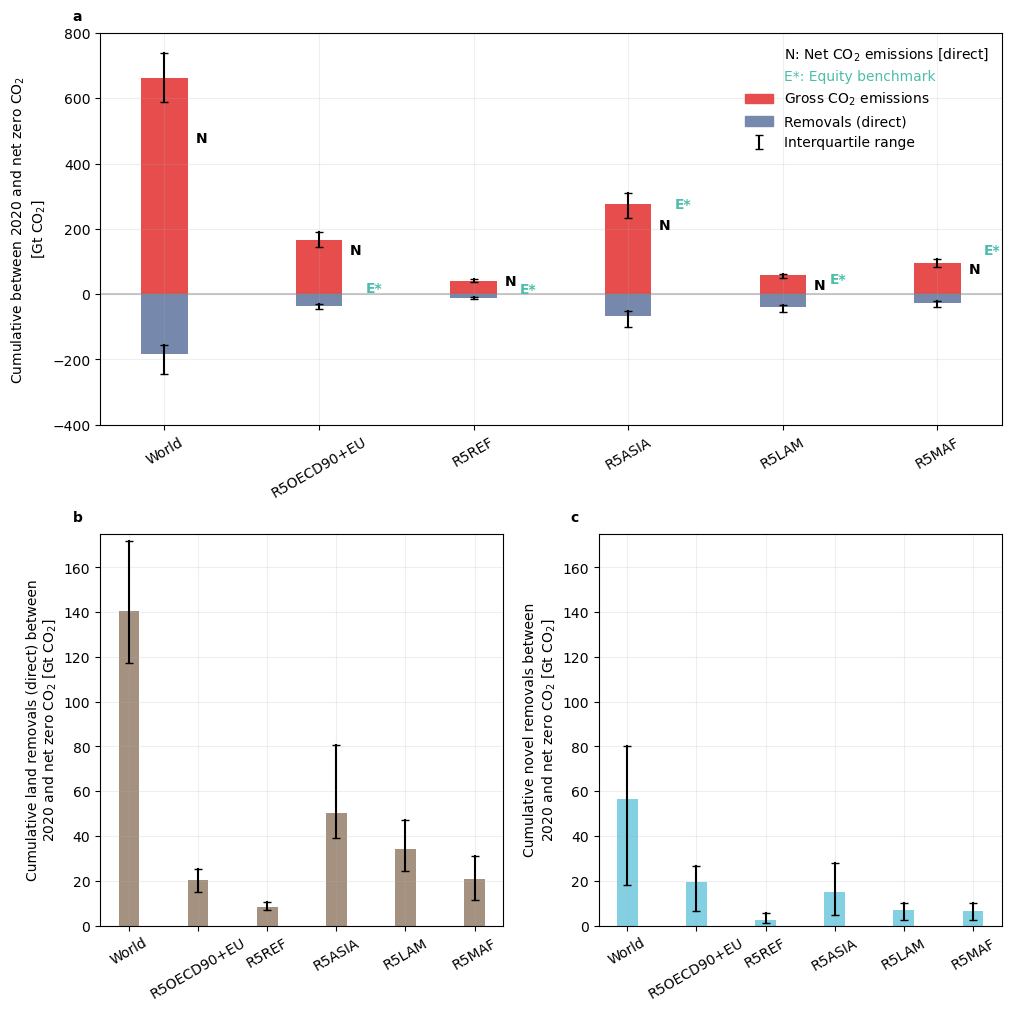

In [13]:
fig, ax = plt.subplot_mosaic(
    [
        ['a', 'a'],
        ['b', 'c']
    ],
    figsize=(10,10),
    constrained_layout=True
)
tot = []
for i, region in enumerate(
    [
        'World',
        'R5OECD90+EU',
        'R5REF',
        'R5ASIA',
        'R5LAM',
        'R5MAF'
    ]
):
    # First, we calculate the cumulative gross CO2 emissions per region
    med, lo, hi = return_cumulative_elements_for_plot(
        variable_components[1],
        region
    )
    print(f'{region} gross: {med}, {lo}, {hi}')
    plot_bar_errors(
        ax['a'],i,med,lo,hi,'#e74d4d',0
    )
    bottom = 0
    med, lo, hi = return_cumulative_elements_for_plot(
        variable_components[0],
        region
    )
    print(f'{region} gross: {med}, {lo}, {hi}')
    plot_bar_errors(
        ax['a'],i,-med,-lo,-hi,'#7688ab',0
    )
    med,_,_ = return_cumulative_elements_for_plot(
        'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
        region
    )
    ax['a'].text(
        s='N',
        x=i+0.2,
        y=med.round(0),
        weight='bold'
    )
    # Now plot the fair share estimate
    if region!='World':
        fair_share_benchmark = (
            fair_shares
            .loc[
                (f'benchmark_{region}', '50%'),
                'C1'
            ]
        )
        ax['a'].text(
            s='E*',
            x=i+0.3,
            y=fair_share_benchmark.round(0),
            weight='bold',
            color='#4dbdab'
        )
ax['a'].axhline(0, color='grey', alpha=0.4)
ax['a'].set_xticks(range(6))

ax['a'].set_ylim(-400, 800)

# Panel b - composition of land-based removals
land_removals_var = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct'
novel_removals_var = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'
for i, region in enumerate(
    [
        'World',
        'R5OECD90+EU',
        'R5REF',
        'R5ASIA',
        'R5LAM',
        'R5MAF'
    ]
):
    med, lo, hi = return_cumulative_elements_for_plot(
        var=land_removals_var,
        reg=region
    )
    plot_bar_errors(
        ax['b'],i,med,lo,hi,'#a5917f',0
    )
    med, lo, hi = return_cumulative_elements_for_plot(
        var=novel_removals_var,
        reg=region
    )
    plot_bar_errors(
        ax['c'],i,med,lo,hi,'#83d0e2',0
    )

ax['b'].set_ylim(0, 175)
ax['c'].set_ylim(0, 175)

for lab,a in ax.items():
    a.grid(alpha=0.2)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    a.text(0.0, 1.0, lab, transform=a.transAxes + trans,
             va='bottom', weight='bold')
    a.set_xticks(range(6))
    a.set_xticklabels([
        'World',
        'R5OECD90+EU',
        'R5REF',
        'R5ASIA',
        'R5LAM',
        'R5MAF'
    ], rotation=30)

line = Line2D([],[], ls="none", color='black')
barline = LineCollection(np.empty((2,2,2)), color='black')

# Make a custom legend for panel a
custom_legend = [
    Line2D([0], [0], color='w', label='N: Net CO$_2$ emissions [direct]'), 
    Line2D([0], [0], color='w', label='E*: Equity benchmark'),
    Patch(facecolor='#e74d4d', label='Gross CO$_2$ emissions', edgecolor='#e74d4d'),
    Patch(facecolor='#7688ab', label='Removals (direct)', edgecolor='#7688ab'),
    ErrorbarContainer((line, [line], [barline]), has_yerr=True, label='Interquartile range')
]
ax['a'].legend(
    handles=custom_legend,
    labelcolor=[
        'black',
        '#4dbdab',
        'black',
        'black',
        'black'
    ],
    framealpha=0.0
)


# Set the y labels as necessary
ax['a'].set_ylabel(
    'Cumulative between 2020 and net zero CO$_2$\n[Gt CO$_2$]'
)

ax['b'].set_ylabel(
    'Cumulative land removals (direct) between\n2020 and net zero CO$_2$ [Gt CO$_2$]'
)

ax['c'].set_ylabel(
    'Cumulative novel removals between\n2020 and net zero CO$_2$ [Gt CO$_2$]'
)


In [12]:
fig.savefig(
    Path(
        'figures/fig2.png'
    ),
    dpi=400,
    bbox_inches='tight'
)

Statement: OECD proportion of global novel removals.

In [15]:
oecd_cumulative = return_cumulative_elements(
    var=novel_removals_var,
    reg='R5OECD90+EU'
)

In [17]:
global_cumulative = return_cumulative_elements(
    var=novel_removals_var,
    reg='World'
)

In [23]:
oecd_cumulative.index = oecd_cumulative.index.droplevel('region')

In [24]:
global_cumulative.index = global_cumulative.index.droplevel('region')

In [29]:
(oecd_cumulative * 100 / global_cumulative).describe().round(0)

count    69.0
mean     36.0
std      10.0
min      13.0
25%      28.0
50%      36.0
75%      40.0
max      65.0
dtype: float64

Now, we proceed to look at the contribution of R5ASIA.

In [32]:
asia_cumulative = return_cumulative_elements(
    var=novel_removals_var,
    reg='R5ASIA'
)
asia_cumulative.index = asia_cumulative.index.droplevel('region')

In [35]:
((asia_cumulative * 100) / global_cumulative).describe().round(0)

count    69.0
mean     31.0
std      12.0
min       5.0
25%      26.0
50%      30.0
75%      38.0
max      68.0
dtype: float64

Proportion of land removals in R5ASIA.

In [38]:
land_cumulative_removal_asia = return_cumulative_elements(
    var=land_removals_var,
    reg='R5ASIA'
)
land_cumulative_removal_asia.index = land_cumulative_removal_asia.index.droplevel('region')

In [39]:
land_cumulative_removal_global = return_cumulative_elements(
    var=land_removals_var,
    reg='World'
)
land_cumulative_removal_global.index = land_cumulative_removal_global.index.droplevel('region')

In [40]:
((land_cumulative_removal_asia * 100) / land_cumulative_removal_global).describe().round(0)

count    70.0
mean     39.0
std      12.0
min      19.0
25%      33.0
50%      36.0
75%      41.0
max      60.0
dtype: float64